In [1]:
try:
    GUTENBERG = True
    from gutenberg.acquire import load_etext
    from gutenberg.query import get_etexts, get_metadata
    from gutenberg.acquire import get_metadata_cache
    from gutenberg.acquire.text import UnknownDownloadUriException
    from gutenberg.cleanup import strip_headers
    from gutenberg._domain_model.exceptions import CacheAlreadyExistsException
except ImportError:
    GUTENBERG = False
    print('Gutenberg is not installed. See instructions at https://pypi.python.org/pypi/Gutenberg')
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
import tensorflow.keras.callbacks
import tensorflow.keras.backend as K
import scipy.misc
import json

import os, sys
import re
import PIL
from PIL import ImageDraw

from tensorflow.keras.optimizers import RMSprop
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import get_file

from IPython.display import clear_output, Image, display, HTML
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

Gutenberg is not installed. See instructions at https://pypi.python.org/pypi/Gutenberg


In [2]:
if GUTENBERG:
    cache = get_metadata_cache()
    try:
        cache.populate()
    except CacheAlreadyExistsException:
        pass

In [3]:
if GUTENBERG:
    for text_id in get_etexts('author', 'Shakespeare, William'):
        print(text_id, list(get_metadata('title', text_id))[0])

In [4]:
if GUTENBERG:
    shakespeare = strip_headers(load_etext(100))
else:
    path = get_file('shakespeare', 'https://storage.googleapis.com/deep-learning-cookbook/100-0.txt')
    shakespeare = open(path).read()
training_text = shakespeare.split('\nTHE END', 1)[-1]
len(training_text)

5592892

In [5]:
chars = list(sorted(set(training_text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
len(chars)

97

In [6]:
def char_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
model = char_rnn_model(len(chars), num_layers=2, num_nodes=640, dropout=0)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 97)          0         
_________________________________________________________________
lstm_layer_1 (UnifiedLSTM)   (None, None, 640)         1889280   
_________________________________________________________________
lstm_layer_2 (UnifiedLSTM)   (None, None, 640)         3279360   
_________________________________________________________________
time_distributed (TimeDistri (None, None, 97)          62177     
Total params: 5,230,817
Trainable params: 5,230,817
Non-trainable params: 0
_________________________________________________________________


In [8]:
CHUNK_SIZE = 160

def data_generator(all_text, char_to_idx, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    y = np.zeros((batch_size, chunk_size, len(char_to_idx)))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(all_text) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, len(char_to_idx)))
            for i in range(chunk_size + 1):
                chunk[i, char_to_idx[all_text[idx + i]]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(training_text, char_to_idx, 4, chunk_size=CHUNK_SIZE))

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0

In [9]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
model.fit_generator(
    data_generator(training_text, char_to_idx, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(training_text) // (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/40
Instructions for updating:
Use tf.cast instead.
 - 60s - loss: 3.4145 - acc: 0.2094
Epoch 2/40
 - 59s - loss: 3.3088 - acc: 0.2186
Epoch 3/40
 - 61s - loss: 3.2921 - acc: 0.2184
Epoch 4/40
 - 61s - loss: 3.2632 - acc: 0.2180
Epoch 5/40
 - 61s - loss: 3.2427 - acc: 0.2186
Epoch 6/40
 - 61s - loss: 3.2332 - acc: 0.2186
Epoch 7/40
 - 61s - loss: 3.2270 - acc: 0.2189
Epoch 8/40
 - 61s - loss: 3.2228 - acc: 0.2187
Epoch 9/40
 - 61s - loss: 3.2145 - acc: 0.2192


In [10]:
os.makedirs('zoo/06', exist_ok=True)
with open('zoo/06/shakespeare.json', 'w') as fout:
    json.dump({
        'chars': ''.join(chars),
        'char_to_idx': char_to_idx,
        'chunk_size': CHUNK_SIZE,
    }, fout)
model.save('zoo/06/shakespeare.h5')

In [11]:
def generate_output(model, training_text, start_index=None, diversity=None, amount=400):
    if start_index is None:
        start_index = random.randint(0, len(training_text) - CHUNK_SIZE - 1)
    generated = training_text[start_index: start_index + CHUNK_SIZE]
    yield generated + '#'
    for i in range(amount):
        x = np.zeros((1, len(generated), len(chars)))
        for t, char in enumerate(generated):
            x[0, t, char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)     
        next_char = chars[next_index]
        yield next_char

        generated += next_char
    return generated

for ch in generate_output(model, training_text):
    sys.stdout.write(ch)
print()
        

ODOVICO. As you shall prove us, praise us.
  IAGO. Signior Lodovico?
  LODOVICO. He, sir.
  IAGO. I cry you mercy. Here's Cassio hurt by villains.
  GRATIANO. C#                                                                                                                                                                                                                                                                                                                                                                                                                


In [12]:
def find_python(rootdir):
    matches = []
    for root, dirnames, filenames in os.walk(rootdir):
        for fn in filenames:
            if fn.endswith('.py'):
                matches.append(os.path.join(root, fn))

    return matches
#  + find_python(os.path.join(sys.executable.rsplit('/', 2)[0], 'lib'))
srcs = find_python(random.__file__.rsplit('/', 1)[0])
len(srcs)

1843

In [13]:
def replacer(value):
    value = ''.join(ch for ch in value if ord(ch) < 127)
    if not ' ' in value:
        return value
    if sum(1 for ch in value if ch.isalpha()) > 6:
        return 'MSG'
    return value


def replace_literals(st):
    res = []
    start_text = start_quote = i = 0
    quote = ''
    while i < len(st):
        if quote:
            if st[i: i + len(quote)] == quote:
                quote = ''
                start_text = i
                res.append(replacer(st[start_quote: i]))
        elif st[i] in '"\'':
            quote = st[i]
            if i < len(st) - 2 and st[i + 1] == st[i + 2] == quote:
                quote = 3 * quote
            start_quote = i + len(quote)
            res.append(st[start_text: start_quote])
        if st[i] == '\n' and len(quote) == 1:
            start_text = i
            res.append(quote)
            quote = ''
        if st[i] == '\\':
            i += 1
        i += 1
    return ''.join(res) + st[start_text:]

#replace_literals('print("hel\\"lo")') + replace_literals("print('hel\\'lo world')")
replace_literals('this = "wrong\n')

'this = ""\n'

In [14]:
COMMENT_RE = re.compile('#.*')
python_code = []
for fn in srcs:
    try:
        with open(fn, 'r') as fin:
            src = fin.read()
    except UnicodeDecodeError:
        print('Could not read %s' % fn)
    src = replace_literals(src)
    src = COMMENT_RE.sub('', src)
    python_code.append(src)

python_code = '\n\n\n'.join(python_code)
len(python_code)

Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/test/badsyntax_pep3120.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/test/test_source_encoding.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/test/encoded_modules/module_iso_8859_1.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/test/encoded_modules/module_koi8_r.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/sqlite3/test/dbapi.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/sqlite3/test/factory.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/sqlite3/test/hooks.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/sqlite3/test/regression.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/sqlite3/test/transactions.py
Could not read /home/mitsuhisa.ohta/.pyenv/versions/3.6.0/lib/python3.6/sqlite3/test/types.py

20510655

In [15]:
py_chars = list(sorted(set(python_code)))
py_char_to_idx = {ch: idx for idx, ch in enumerate(py_chars)}
len(py_chars)

111

In [16]:
py_model = char_rnn_model(len(py_chars), num_layers=2, num_nodes=640, dropout=0)
py_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 111)         0         
_________________________________________________________________
lstm_layer_1 (UnifiedLSTM)   (None, None, 640)         1925120   
_________________________________________________________________
lstm_layer_2 (UnifiedLSTM)   (None, None, 640)         3279360   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 111)         71151     
Total params: 5,275,631
Trainable params: 5,275,631
Non-trainable params: 0
_________________________________________________________________


In [18]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
py_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) // (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
 - 223s - loss: 3.2873 - acc: 0.3038
Epoch 2/40
 - 227s - loss: 3.0013 - acc: 0.3242
Epoch 3/40
 - 227s - loss: 2.1042 - acc: 0.5151
Epoch 4/40
 - 227s - loss: 1.8316 - acc: 0.5918
Epoch 5/40
 - 228s - loss: 1.7530 - acc: 0.6146
Epoch 6/40
 - 228s - loss: 1.7288 - acc: 0.6238
Epoch 7/40
 - 229s - loss: 1.6754 - acc: 0.6380
Epoch 8/40
 - 228s - loss: 1.6944 - acc: 0.6367
Epoch 9/40
 - 229s - loss: 1.6279 - acc: 0.6525
Epoch 10/40
 - 228s - loss: 1.5428 - acc: 0.6717
Epoch 11/40
 - 228s - loss: 1.5672 - acc: 0.6686
Epoch 12/40
 - 228s - loss: 1.5173 - acc: 0.6803
Epoch 13/40
 - 229s - loss: 1.5303 - acc: 0.6789


In [19]:
def generate_code(model, start_with='\ndef ', end_with='\n\n', diversity=1.0):
    generated = start_with
    yield generated
    for i in range(2000):
        x = np.zeros((1, len(generated), len(py_chars)))
        for t, char in enumerate(generated):
            x[0, t, py_char_to_idx[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        
        preds = np.asarray(preds[len(generated) - 1]).astype('float64')
        preds = np.log(preds) / diversity
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        next_index = np.argmax(probas)        
        next_char = py_chars[next_index]
        yield next_char

        generated += next_char
        if generated.endswith(end_with):
            break

for i in range(20):
    st = ""
    for ch in generate_code(py_model):
        sys.stdout.write(ch)
        st += ch
    print(st)



def sl(s):
 
  elseVar_set(s[X], lenclG0) w, H
e.clewn = socket._AllHey()


def sl(s):
 
  elseVar_set(s[X], lenclG0) w, H
e.clewn = socket._AllHey()



def no_eig_neek(args = '*': token.nuc(eeumc * ERR_R | ar 60.01, noE = sectionee + 0) t2 usion'
   tr6:2pna = bfile(e1:01.messt * 12)le,
        4502 + sys.maxsize * 1d48)
     a[ ord.remOve .c
    yield fr in config:        
    a = '\  '
    len = sy(delimite - 2n + 0]
    eesli = aibbern[name.rpwir]polu](tri arg no self._lengthed2.cmp(hath.fl,))
    try:
        cttl_lambda .umdiE + 
       (bt, col / minaroi callable + _end_tas.flags)
0.55 =  mash(dot,2)
 prinC("  leifi /3t")


def no_eig_neek(args = '*': token.nuc(eeumc * ERR_R | ar 60.01, noE = sectionee + 0) t2 usion'
   tr6:2pna = bfile(e1:01.messt * 12)le,
        4502 + sys.maxsize * 1d48)
     a[ ord.remOve .c
    yield fr in config:        
    a = '\  '
    len = sy(delimite - 2n + 0]
    eesli = aibbern[name.rpwir]polu](tri arg no self._lengthed2.cmp(hath.fl,))
    try:
 

  elv , rel
  typea0 = k3 = '(%asaP,))|sTh >
     letters = _alashapx_ and notdod1.token
"Qut struct_dialed"    
    return restore.l + ast.leni > jecor 
pa" -' + None
    a = getattr(None, e - 10() | a)
    if not arg: self.memo = notmp and   
        name = ""
    Gtu%
        isMen =  (1  
            ==UrdtestHaearHash9  2s &  
enuI = _SSLS" + __meou__(incent='t s '/, \s this@-5 &' + altche / '- '.joinosame(filenoea=Oase  3futel x)  '.F2 un'


def match(ma  (name,idle_ttr, meta _str)
287s !> y'oma'    (u'   ').fr ir grou=e2aven1 = (, UserString=' 'E GetSequenceU0PIP-testingiati ') +
 len(req == 1 eLsufeLo <sSVar'):
    return _6 \
  e, eval('MS -= 7oiar')s1)
    rf is a\rf'r'__ iarout = 0.105
    edrtasx2  ='e'
    else max_relativsummydel ==1, t
    allow_mhesexte,imp + het(observed + 8)' + other.entry%2 - 1/2
       y = uctercd + 1>8
   o, uncompat, args, kwargs | k
  elv , rel
  typea0 = k3 = '(%asaP,))|sTh >
     letters = _alashapx_ and notdod1.token
"Qut struct_dialed"    
  

In [20]:
BATCH_SIZE = 512

flat_model = char_rnn_model(len(py_chars), num_layers=1, num_nodes=512, dropout=0)

early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

flat_model.fit_generator(
    data_generator(python_code, py_char_to_idx, batch_size=BATCH_SIZE, chunk_size=160),
    epochs=40,
    callbacks=[early,],
    steps_per_epoch=2 * len(python_code) // (BATCH_SIZE * 160),
    verbose=2
)

Epoch 1/40
 - 93s - loss: 2.6634 - acc: 0.3969
Epoch 2/40
 - 93s - loss: 2.1989 - acc: 0.4998
Epoch 3/40
 - 94s - loss: 2.0744 - acc: 0.5351
Epoch 4/40
 - 95s - loss: 2.0181 - acc: 0.5520
Epoch 5/40
 - 95s - loss: 1.9750 - acc: 0.5641
Epoch 6/40
 - 95s - loss: 1.9242 - acc: 0.5774
Epoch 7/40
 - 95s - loss: 1.9056 - acc: 0.5832
Epoch 8/40
 - 95s - loss: 1.8835 - acc: 0.5895
Epoch 9/40
 - 95s - loss: 1.9003 - acc: 0.5870
Epoch 10/40
 - 95s - loss: 1.8806 - acc: 0.5922
Epoch 11/40
 - 95s - loss: 1.8512 - acc: 0.5995
Epoch 12/40
 - 95s - loss: 1.8563 - acc: 0.5993
Epoch 13/40
 - 95s - loss: 1.8239 - acc: 0.6069
Epoch 14/40
 - 95s - loss: 1.8536 - acc: 0.6010


In [21]:
example_code = 'if a == 2:\n    b=1\nelse:\n    b=2\n'
#example_code = 'a=(2 * 3)\nb=(4 * 6 + 7)\nreturn C'

def activations(model, code):
    x = np.zeros((1, len(code), len(py_char_to_idx)))
    for t, char in enumerate(code):
        x[0, t, py_char_to_idx[char]] = 1.
    output = model.get_layer('lstm_layer_1').output
    f = K.function([model.input], [output])
    return f([x])[0][0]

act = activations(flat_model, example_code)
act.shape

(33, 512)

In [22]:
def interesting_neurons(act):
    res = []
    for n in np.argmax(act, axis=1):
        if not n in res:
            res.append(n)
    return res

neurons = interesting_neurons(act)
len(neurons)

21

/home/mitsuhisa.ohta/.pyenv/versions/3.6.0/envs/dlc_org/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


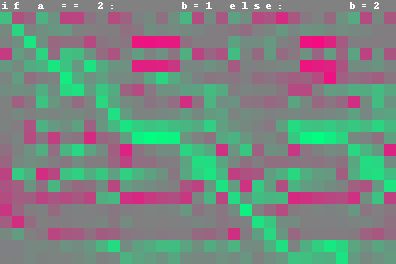

In [23]:
def visualize_neurons(neurons, code, act, cell_size=12):
    img = np.full((len(neurons) + 1, len(code), 3), 128)
    scores = (act[:, neurons].T + 1) / 2
    img[1:, :, 0] = 255 * (1 - scores)
    img[1:, :, 1] = 255 * scores

    f = BytesIO()
    img = scipy.misc.imresize(img, float(cell_size), interp='nearest')
    pil_img = PIL.Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)
    for idx, ch in enumerate(code):
        draw.text((idx * cell_size + 2, 0), ch)
    pil_img.save(f, 'png')
    return Image(data=f.getvalue())

img = visualize_neurons(neurons, example_code, act)
display(img)

/home/mitsuhisa.ohta/.pyenv/versions/3.6.0/envs/dlc_org/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


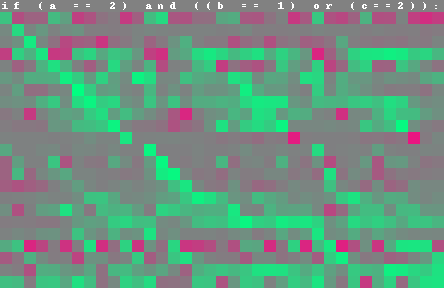

In [24]:
def image_for_code(code):
    act = activations(flat_model, code)
    neurons = interesting_neurons(act)
    return visualize_neurons(neurons, code, act)

display(image_for_code('if (a == 2) and ((b == 1) or (c==2)):'))

In [25]:
code = 'if (a == 2) and ((b == 1) or (c==2)):'
mask = '   ________     ____________________ '
act = activations(flat_model, code)
positive = [idx for idx, ch in enumerate(mask) if ch == '_']
negative = [idx for idx, ch in enumerate(mask) if ch != '_']

neurons = np.argsort(act[positive].sum(axis=0) - act[negative].sum(axis=0))[-5:]

/home/mitsuhisa.ohta/.pyenv/versions/3.6.0/envs/dlc_org/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


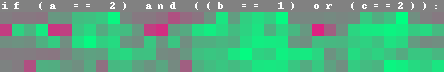

In [26]:
img = visualize_neurons(neurons, code, act)
display(img)

In [27]:
neurons

array([192, 218, 427,  43, 219])

In [28]:
act[negative, 108].sum()

-1.1803046

In [29]:
x0 = 0
x1 = 0
for idx, ch in enumerate(mask):
    if ch == '_':
        x0 += act[idx, 108]
    else:
        x1 += act[idx, 108]
x0, x1

(-1.736106727272272, -1.1803045719861984)